In [1]:
import numpy as np
np.set_printoptions(threshold=1000)

import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

from keras.callbacks import LearningRateScheduler, History

Using TensorFlow backend.


In [2]:
import sys
sys.path.insert(0, '/home/albert/research/vbranch/code/src/')
import evaluation,data, training, models
# from src.bk import models_bk2

In [3]:
# import models_no_tile

### Load Data

In [4]:
# Batch parameters for batch-hard triplet loss
P_param = 4
K_param = 4

In [5]:
train_dict, train_files = data.get_data('train')

0.0787448883057


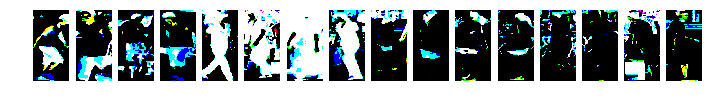

In [6]:
start = time.time()
batch = data.batch_generator(train_dict, P=P_param, K=K_param, preprocess=True,
                                    shape=(256,128)).next()
print time.time() - start

i = 0

plt.figure(figsize=(15,2))
for j in range(P_param*K_param):
    plt.subplot(1,20,j+1)
    im = batch[0][i][j].squeeze().astype(np.uint8)
#         print im.min(), im.max()
    plt.imshow(im)
    plt.axis('off')
plt.show()

### Define Learning Rate Schedule

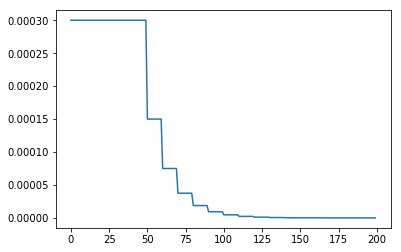

In [7]:
epochs = 10
steps_per_epoch = 100

lr = []
for era in range(1,21):
#     exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(training.step_decay_cont(epochs, era)(j))
plt.plot(np.arange(200), lr)

### Define Model

In [8]:
model, masks = models.DenseNetDrop(P_param=P_param, K_param=K_param,
                                    weights='imagenet', diagnostic=True, 
                                  blocks=3, tile=False, n_pool=-1)

[-1, 0, 1, 2]
l_start 138
[-1, 0, 1, 2]
Weights for the model were loaded successfully
[<tf.Tensor 'lambda_454/Reshape:0' shape=(?, ?) dtype=float32>, <tf.Tensor 'lambda_455/Reshape:0' shape=(?, ?) dtype=float32>, <tf.Tensor 'lambda_456/Reshape:0' shape=(?, ?) dtype=float32>]
0.2
[0, 128, 256, 384]
(16, 128)
(16, 128)
(16, 128)


In [9]:
for l in range(len(model.layers)):
    print l, model.layers[l].name , model.layers[l].inbound_nodes

0 input_2 [<keras.engine.topology.Node object at 0x7fd02958e950>]
1 conv2d_121 [<keras.engine.topology.Node object at 0x7fd02958e710>]
2 batch_normalization_206 [<keras.engine.topology.Node object at 0x7fd01f616d90>]
3 activation_123 [<keras.engine.topology.Node object at 0x7fd01f637910>]
4 max_pooling2d_2 [<keras.engine.topology.Node object at 0x7fd01f637a50>]
5 batch_normalization_207 [<keras.engine.topology.Node object at 0x7fd01f542250>]
6 activation_124 [<keras.engine.topology.Node object at 0x7fd01f616150>]
7 conv2d_122 [<keras.engine.topology.Node object at 0x7fd02958ef10>]
8 batch_normalization_208 [<keras.engine.topology.Node object at 0x7fd01f4ca7d0>]
9 activation_125 [<keras.engine.topology.Node object at 0x7fd01f593150>]
10 conv2d_123 [<keras.engine.topology.Node object at 0x7fd029498110>]
11 concatenate_59 [<keras.engine.topology.Node object at 0x7fd01f533610>]
12 batch_normalization_209 [<keras.engine.topology.Node object at 0x7fd01f456c10>]
13 activation_126 [<keras.engi

1173 lambda_433 [<keras.engine.topology.Node object at 0x7fd0190097d0>]
1174 lambda_434 [<keras.engine.topology.Node object at 0x7fd019027f10>]
1175 lambda_435 [<keras.engine.topology.Node object at 0x7fd019018b10>]
1176 concatenate_100 [<keras.engine.topology.Node object at 0x7fd019027e90>, <keras.engine.topology.Node object at 0x7fd01903a390>, <keras.engine.topology.Node object at 0x7fd01903af90>]
1177 batch_normalization_171 [<keras.engine.topology.Node object at 0x7fd018ff45d0>, <keras.engine.topology.Node object at 0x7fd018fe15d0>, <keras.engine.topology.Node object at 0x7fd018fa2d10>]
1178 input_438 [<keras.engine.topology.Node object at 0x7fd01fa6d790>]
1179 input_439 [<keras.engine.topology.Node object at 0x7fd01fa6d990>]
1180 input_440 [<keras.engine.topology.Node object at 0x7fd01fa6db90>]
1181 lambda_436 [<keras.engine.topology.Node object at 0x7fd019027750>]
1182 lambda_437 [<keras.engine.topology.Node object at 0x7fd018ff4a50>]
1183 lambda_438 [<keras.engine.topology.Node 

In [4]:
# model_eval = models.DenseNetDrop(blocks=4, tile=False)
model_eval = models.DenseNetDrop(blocks=3, tile=False, n_pool=-1)

[-1, 0, 1, 2]
l_start 138
[-1, 0, 1, 2]
[<tf.Tensor 'lambda_454/Reshape:0' shape=(?, ?) dtype=float32>, <tf.Tensor 'lambda_455/Reshape:0' shape=(?, ?) dtype=float32>, <tf.Tensor 'lambda_456/Reshape:0' shape=(?, ?) dtype=float32>]
0.2
[0, 128, 256, 384]
(1, 128)
(1, 128)
(1, 128)


In [9]:
from keras.models import Model
test = Model(model.inputs, model.layers[1202].get_output_at(0))
print test.predict(batch[0])[0,0,0]

IndexError: too many indices for array

In [5]:
model.summary()

NameError: name 'model' is not defined

In [10]:
history = History()
for era in range(1,16):
    iterations = era * epochs * steps_per_epoch
    lrate = LearningRateScheduler(training.step_decay_cont(epochs, era))

    print 'era, ' + str(era)

    model.fit_generator(data.batch_generator(train_dict, P=P_param, K=K_param,
                            preprocess=True, shape=(256,128)),
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate,history])

    path = training.save_weights(model, it=iterations, root='vbranch_P5K4_pool3-1')
    model_eval.set_weights(model.get_weights())

    print evaluation.get_score(model_eval, hist=history, inputs=1)

era, 1
Epoch 1/10
100/100 [==============================] - 74s - loss: 418.1270    
Epoch 2/10
100/100 [==============================] - 69s - loss: 300.2862    
Epoch 3/10
100/100 [==============================] - 69s - loss: 238.9652    
Epoch 4/10
100/100 [==============================] - 69s - loss: 204.8882    
Epoch 5/10
100/100 [==============================] - 70s - loss: 185.7745    
Epoch 6/10
100/100 [==============================] - 70s - loss: 159.1416    
Epoch 7/10
100/100 [==============================] - 69s - loss: 141.4951    
Epoch 8/10
100/100 [==============================] - 69s - loss: 125.8818    
Epoch 9/10
100/100 [==============================] - 69s - loss: 117.5355    
Epoch 10/10
100/100 [==============================] - 69s - loss: 105.4304    


NameError: name 'model_eval' is not defined

In [ ]:
for it in range(1000, 14000, 1000):
    model_eval.set_weights(np.load('../models/vbranch_P5K4_pool3/vbranch_P5K4_pool3_%d.npy' % it))
    print evaluation.get_score(model_eval, inputs=1)

1000 32.0510220528
2000 62.7872691154
3000 93.5579931736
4000 124.50256896
5000 155.326406956
6000 186.206029177
7000 217.035036087
8000 248.020890951
9000 279.187198162
10000 310.752473116
11000 341.946381092
12000 372.790241003
13000 403.595494986
14000 434.418421984
15000 465.215451956
1000 31.0494339466
2000 61.9070990086
3000 92.8035700321
metric time: 239.522658
{'mAP': 0.1946, 'rank': {'r5': 0.6102, 'r1': 0.3798}, 'loss': []}
1000 30.8311831951
2000 61.5797841549
3000 92.4243471622
4000 123.25825119
5000 154.27691412
6000 185.317574024
7000 216.197736025
8000 247.010668993
9000 277.843718052
10000 308.750178099
11000 339.648357153
12000 370.464063168
13000 401.359579086
14000 432.669183016
15000 463.600205183
1000 30.796298027
2000 61.60404706
3000 92.4024970531
metric time: 238.681904
{'mAP': 0.29780000000000001, 'rank': {'r5': 0.7476, 'r1': 0.5101}, 'loss': []}
1000 30.7170619965
2000 61.4565570354
3000 92.2118310928
4000 122.944692135
5000 153.757560015
6000 184.561289072
700

vbranch_P5K4 <br>
1000: r1=0.49 <br>
2000: {'mAP': 0.36899999999999999, 'rank': {'r5': 0.7931, 'r1': 0.5799}, 'loss': []} <br>
3000: {'mAP': 0.35020000000000001, 'rank': {'r5': 0.7755, 'r1': 0.5647}, 'loss': []} <br>
12000: {'mAP': 0.5544, 'rank': {'r5': 0.9062, 'r1': 0.7402}, 'loss': []}